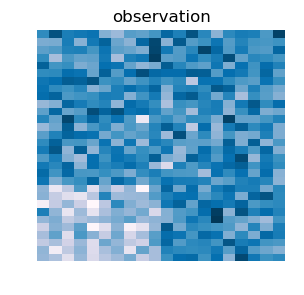

In [131]:
using PyPlot, LightGraphs
srand(1)
#t = [ones(10,10) * 10 ones(10,10) * 5; -ones(20,10) * 5 zeros(20,10)];
t = [ones(10,10) * 0 ones(10,10); ones(20,10) ones(20,10)] * 2;
y = t + randn(30,20);
fig, ax = subplots(figsize = (3.2,3)); pcolormesh(y, cmap = "PuBu"); axis("off"); title("observation");

In [132]:
# a function for BSGM_cartesian_biclust (Section 5.2.)

# y       : a matrix of data
# init    : initialization of y

function BSGM_cartesian_biclust(y;
                                init = y,
                                v0 = 1e-1,
                                convtol = 1e-14,  
                                iter = 10)
                            
    
    # get size
    n1,n2 = size(y); n = n1 * n2;
    
    
    # initialize
    theta = copy(y);
    mu1 = copy(y); mu2 = copy(y);
    q1 = zeros(n1,n1); q2 = zeros(n2,n2);
    sigmasq1 = 1; sigmasq2 = 1;
    
    # loop start
    for i = 1:iter
        
        # save previous iteration
        q1_old = copy(q1);
        q2_old = copy(q2);
        
        # E-step: update g1
        d1 = reshape(sum((repmat(theta,n1,1) - kron(mu1,ones(n1))).^2,2),n1,n1);
        q1 = exp.(-d1/(2*n2*v0)); q1 = q1 ./ sum(q1,2);
        
        # E-step: update g2
        d2 = reshape(sum((repmat(theta',n2,1) - kron(mu2',ones(n2))).^2,2),n2,n2)';
        q2 = exp.(-d2/(2*n1*v0)); q2 = q2 ./ sum(q2,2);
        
        # M-step: update theta
        L1 = (speye(n1) - (q1 ./ sum(q1,1)) * q1')/v0;
        L2 = (speye(n2) - (q2 ./ sum(q2,1)) * q2')/v0;
        L = kron(L2, speye(n1)) + kron(speye(n2),L1);
        theta = reshape((speye(n) + L)\y[:], n1,n2);
        mu1 = (q1 ./ sum(q1,1))' * theta;
        mu2 = theta * (q2 ./ sum(q2,1));
        
        if rem(i,5) == 0
            @printf "%3d-th iteration done: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
        end
        
        if norm(q1 - q1_old) + norm(q2 - q2_old) < convtol
            @printf "the algorithm converged at %3d-th iteration: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
            break;
        end
        
    end
    
    return Dict([
                (:theta, theta), (:q1, q1), (:q2, q2), (:mu1, q1 * mu1 * q2'), (:mu2, q1 * mu2 * q2')
                ])
end

BSGM_cartesian_biclust (generic function with 1 method)

In [133]:
out = BSGM_cartesian_biclust(y, v0 = 1e-1/1.4, iter = 100);

  5-th iteration done: error = 7.20e-01
 10-th iteration done: error = 1.12e+00
 15-th iteration done: error = 7.18e-03
 20-th iteration done: error = 1.27e-13
the algorithm converged at  21-th iteration: error = 1.16e-15


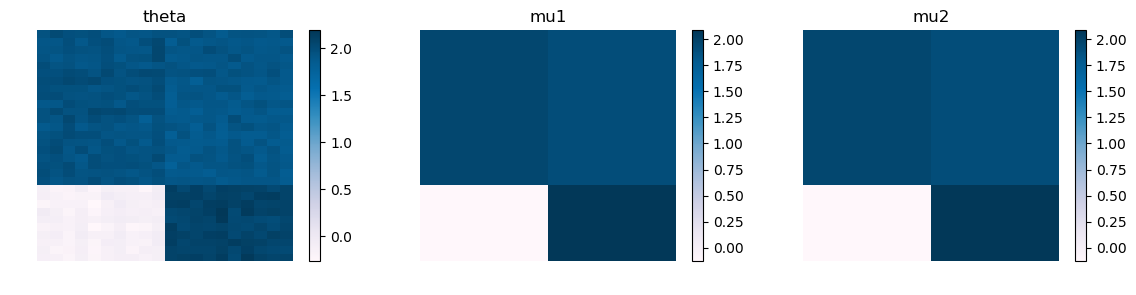

In [134]:
fig, ax = subplots(1,3, figsize = (14,3))
subplot(131); pcolormesh(out[:theta], cmap = "PuBu"); axis("off"); title("theta"); colorbar();
subplot(132); pcolormesh(out[:mu1], cmap = "PuBu"); axis("off"); title("mu1"); colorbar();
subplot(133); pcolormesh(out[:mu2], cmap = "PuBu"); axis("off"); title("mu2"); colorbar();